## Import modules

In [1]:
import os
import sys
import math
from collections import OrderedDict
import copy
import random
import glob
from easydict import EasyDict
from typing import Dict, List
import time
os.chdir('/home/yuanyu/projects/rush')

import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.nn.init as init
import torch.utils.data as data
import torch.utils.data.dataset as dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from skimage import exposure, img_as_float

from models.MNAD.model.utils import CustomDataLoader
from models.MNAD.model.final_future_prediction_with_memory_spatial_sumonly_weight_ranking_top1 import *
from models.MNAD.model.Reconstruction import *
from models.MNAD.utils import *
import urls

## 1 Set configs and environment

In [2]:
id = 51
cfg = EasyDict(
    # dataset
    video_folder='/home/yuanyu/projects/data/DaYanTa_2/8_C' + str(id) + '/frames_select',
    label_file_path='/home/yuanyu/projects/rush/process_xian_video_for_VAD/label_dyt_' + str(id) + '_0429.csv',
    transform=transforms.Compose([transforms.ToTensor()]),
    resized_height=256,
    resized_width=256,
    time_step=4,
    num_pred=1,

    # model
    method='pred',
    t_length=5,
    fdim=512,
    mdim=512,
    msize=10,

    # test
    model_path='./models/MNAD/exp/Xian/pred/log' + str(id) + '/model.pth',
    m_items_path='./models/MNAD/exp/Xian/pred/log' + str(id) + '/keys.pt',
    log_dir='./xian_results/' + str(id),
    gpus='1,2,3',
    batch_size=1,
    num_workers=1,

    alpha=1,
    th=0.01,
    loss_func_mse=nn.MSELoss(reduction='none'),
)

if not os.path.exists(cfg.log_dir):
    os.mkdir(cfg.log_dir)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpus
# make sure to use cudnn for computational performance
torch.backends.cudnn.enabled = True

## 2 Load the dataset and model

In [4]:
# init dataloader
test_dataset = CustomDataLoader(cfg.video_folder, transforms.Compose([
    transforms.ToTensor(),
]), label_file_path=cfg.label_file_path,
    resize_height=cfg.resized_height, resize_width=cfg.resized_width, time_step=cfg.t_length-1, train=False)

test_loader = data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, drop_last=False)

0 5


In [5]:
# init model
model = torch.load(cfg.model_path)
model.cuda()
model.eval()
m_items = torch.load(cfg.m_items_path)

In [6]:
# log and test data_loader
print(len(test_loader))
for data in test_loader:
    print(type(data), data.shape)
    break

3725
<class 'torch.Tensor'> torch.Size([1, 15, 256, 256])


In [7]:
# log and test model
for imgs in test_loader:
    imgs = imgs.cuda()
    outputs, feas, updated_feas, m_items, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(
        imgs[:, 0:3*4], m_items, False
    )
    mse_imgs = cfg.loss_func_mse((outputs[0]+1)/2, (imgs[0, 3*4:]+1)/2)
    mse_loss = torch.mean(mse_imgs).item()
    mse_feas = compactness_loss.item()
    
    print(mse_loss)
    break

0.0002214925189036876


## 3 Run the model on dataloader, and save results

In [8]:
# Init result savers
results = dict()

video_name_list = list()

mse_imgs_list = list()
mse_loss_list = list()
psnr_list = list()

In [9]:
for i, imgs in enumerate(test_loader):
    imgs = imgs.cuda()
    outputs, feas, updated_feas, m_items, softmax_score_query, softmax_score_memory, _, _, _, compactness_loss = model.forward(
        imgs[:, 0:3*4], m_items, False
    )
    mse_imgs = cfg.loss_func_mse((outputs[0]+1)/2, (imgs[0, 3*4:]+1)/2)
    mse_loss = torch.mean(mse_imgs).item()
    mse_feas = compactness_loss.item()
    psnr_ = psnr(mse_loss)

    print(i, mse_loss)
    torch.save({
        'mse_imgs': mse_imgs,
        'mse_loss': mse_loss,
        'psnr': psnr_
    }, f'{cfg.log_dir}/result_{i}.pt')

0 0.0002214925189036876
1 0.0001961670641321689
2 0.00020546989981085062
3 0.0002038524835370481
4 0.00018461878062225878
5 0.00018488992645870894
6 0.00025554740568622947
7 0.00020045966084580868
8 0.00019795993284787983
9 0.00021047254267614335
10 0.00021305684640537947
11 0.00020475049677770585
12 0.00019019241153728217
13 0.00020287753432057798
14 0.00028017067234031856
15 0.00021564250346273184
16 0.0002145899343304336
17 0.00021794586791656911
18 0.0006509246304631233
19 0.00030688001425005496
20 0.00024101146846078336
21 0.00023009610595181584
22 0.0002592784585431218
23 0.00023362277715932578
24 0.0002414218324702233
25 0.000227230935706757
26 0.0002519505505915731
27 0.00020299755851738155
28 0.0002441405667923391
29 0.0002449773601256311
30 0.0002849781303666532
31 0.00022669722966384143
32 0.0002098332333844155
33 0.0001980696542887017
34 0.00023246053024195135
35 0.0001989862648770213
36 0.00021066563203930855
37 0.00020969289471395314
38 0.0002537121472414583
39 0.00029130

315 0.0003245760453864932
316 0.0002514882944524288
317 0.00021459969866555184
318 0.0006578980828635395
319 0.0003304549609310925
320 0.0002583526656962931
321 0.00023992429487407207
322 0.00023831349972169846
323 0.00021325977286323905
324 0.0002469643659424037
325 0.00022252925555221736
326 0.00023452156165149063
327 0.00019983439415227622
328 0.00027851585764437914
329 0.00020478985970839858
330 0.0002258963359054178
331 0.000208515819394961
332 0.00021903912420384586
333 0.00021570341777987778
334 0.00021106749773025513
335 0.00020439234504010528
336 0.0002078648831229657
337 0.00018719153013080359
338 0.00019600427185650915
339 0.00019686977611854672
340 0.00032829734846018255
341 0.00020333629800006747
342 0.00020995356317143887
343 0.0006020599976181984
344 0.00032790270051918924
345 0.0002345499087823555
346 0.00021546659991145134
347 0.0002216168213635683
348 0.00019774833344854414
349 0.0002186354686273262
350 0.0002064613945549354
351 0.00020939038950018585
352 0.0002800540

631 0.00048284162767231464
632 0.0004994438495486975
633 0.00040561516652815044
634 0.00044053266174159944
635 0.00047592626651749015
636 0.0005308941472321749
637 0.00047623165301047266
638 0.0005651075625792146
639 0.00042416760697960854
640 0.0004946424742229283
641 0.0004564861301332712
642 0.0005366445984691381
643 0.0010718358680605888
644 0.0005023316480219364
645 0.0004532115417532623
646 0.0004455751914065331
647 0.0004541368398349732
648 0.000453173735877499
649 0.00047273648669943213
650 0.0005205351044423878
651 0.0004426406230777502
652 0.00044089611037634313
653 0.00042533589294180274
654 0.0004806987417396158
655 0.000491826853249222
656 0.00045429798774421215
657 0.00044518866343423724
658 0.00043014809489250183
659 0.0004040595958940685
660 0.0004520486108958721
661 0.0004152533074375242
662 0.0005607022321783006
663 0.0004576783103402704
664 0.0005258471937850118
665 0.0005532691720873117
666 0.0005562560399994254
667 0.0006089583039283752
668 0.0010785276535898447
66

951 0.00032688627834431827
952 0.000363118335371837
953 0.0003409615019336343
954 0.0003500552847981453
955 0.00035232672234997153
956 0.00031913333805277944
957 0.00035424926318228245
958 0.00030710743158124387
959 0.0003895136760547757
960 0.00036487955367192626
961 0.00033525176695548
962 0.00034245598362758756
963 0.0008591464138589799
964 0.000422088080085814
965 0.0004009753465652466
966 0.0003685048723127693
967 0.0004209370817989111
968 0.00033662826172076166
969 0.0003631202853284776
970 0.0003963936760555953
971 0.0004025296657346189
972 0.00039999576983973384
973 0.0003802410210482776
974 0.0004255141830071807
975 0.00038266164483502507
976 0.00035010825376957655
977 0.0003449642099440098
978 0.0003560858895070851
979 0.00041896215407177806
980 0.00031737168319523335
981 0.00033497539698146284
982 0.00034346789470873773
983 0.0003922595060430467
984 0.0003608409024309367
985 0.0004176980582997203
986 0.0004055681638419628
987 0.00040030968375504017
988 0.0008543845033273101


1257 0.0002370179136050865
1258 0.0002613885444588959
1259 0.00022706479649059474
1260 0.00021240621572360396
1261 0.0002455004141665995
1262 0.000245197064941749
1263 0.0007257141987793148
1264 0.00036614970304071903
1265 0.0002974482486024499
1266 0.00027945556212216616
1267 0.00025220689713023603
1268 0.0002494300715625286
1269 0.00027316066552884877
1270 0.00025291595375165343
1271 0.000357600103598088
1272 0.00023647744092158973
1273 0.00023758187307976186
1274 0.0002447656588628888
1275 0.0002978256961796433
1276 0.0002512158243916929
1277 0.0002494494547136128
1278 0.00024820290855132043
1279 0.00022430733952205628
1280 0.00023684470215812325
1281 0.0002502339775674045
1282 0.0002435985952615738
1283 0.00022797926794737577
1284 0.00022544991225004196
1285 0.0002173000102629885
1286 0.0002366143453400582
1287 0.00027332070749253035
1288 0.0006249983562156558
1289 0.0003536525182425976
1290 0.0002604814653750509
1291 0.00022221931430976838
1292 0.00024124805349856615
1293 0.000216

1557 0.0004244638839736581
1558 0.0009272112511098385
1559 0.0004953158204443753
1560 0.00039634082349948585
1561 0.000490938313305378
1562 0.00036537530831992626
1563 0.000458243943285197
1564 0.000422834069468081
1565 0.0003601491334848106
1566 0.00037994893500581384
1567 0.00040618571802042425
1568 0.00041922059608623385
1569 0.00038659395067952573
1570 0.0003875337424688041
1571 0.00039495129021815956
1572 0.00047523522516712546
1573 0.000467091565951705
1574 0.0004612245538737625
1575 0.0004277888801880181
1576 0.00039269664557650685
1577 0.00040697967051528394
1578 0.0004055167082697153
1579 0.00040522863855585456
1580 0.0004154794733040035
1581 0.0004165225545875728
1582 0.0004075212636962533
1583 0.0008813203312456608
1584 0.0004753275716211647
1585 0.0004126317799091339
1586 0.0004137976502534002
1587 0.0004354442935436964
1588 0.0005403332179412246
1589 0.00039879881660453975
1590 0.0003888959181495011
1591 0.0003944211348425597
1592 0.00048231816617771983
1593 0.000408606894

1862 0.0003098200249951333
1863 0.00034071304253302515
1864 0.0004715761751867831
1865 0.00033535429975017905
1866 0.00038948841392993927
1867 0.00035904691321775317
1868 0.000339239340974018
1869 0.00033430015901103616
1870 0.0003437775594647974
1871 0.0003129220276605338
1872 0.0003285259008407593
1873 0.00036158747388981283
1874 0.00033175150747410953
1875 0.0003266742860432714
1876 0.0003170614945702255
1877 0.0003040548472199589
1878 0.00034261506516486406
1879 0.000290416443021968
1880 0.0003462570603005588
1881 0.0003660690854303539
1882 0.0003393784863874316
1883 0.0008216087589971721
1884 0.0004896082682535052
1885 0.0005016145878471434
1886 0.0005127660115249455
1887 0.0004692517395596951
1888 0.00046212421148084104
1889 0.0004813603009097278
1890 0.0005184951587580144
1891 0.0004910979769192636
1892 0.0004689238849096
1893 0.0004715556278824806
1894 0.0005035509821027517
1895 0.0006460165604948997
1896 0.0005391637096181512
1897 0.0007066240068525076
1898 0.00055111490655690

2166 0.0005385380354709923
2167 0.0004854912986047566
2168 0.0004586785507854074
2169 0.000450293708126992
2170 0.00045209130621515214
2171 0.0004619694664143026
2172 0.0004452473658602685
2173 0.00047635959344916046
2174 0.00043730539618991315
2175 0.0004786698264069855
2176 0.00048396358033642173
2177 0.0004859301261603832
2178 0.0004710507928393781
2179 0.00045336520997807384
2180 0.00045561790466308594
2181 0.00043154400191269815
2182 0.00040696002542972565
2183 0.0009862148435786366
2184 0.0005762181244790554
2185 0.00047105865087360144
2186 0.000443982396973297
2187 0.00045906048035249114
2188 0.0005149446660652757
2189 0.00048220003372989595
2190 0.0004436016024556011
2191 0.0005320929922163486
2192 0.0004486487596295774
2193 0.000426625570980832
2194 0.0004269136115908623
2195 0.00045089173363521695
2196 0.00048330624122172594
2197 0.00048723199870437384
2198 0.00046715489588677883
2199 0.0004809130623470992
2200 0.0005484820576384664
2201 0.0004782979085575789
2202 0.000448252

2467 0.0003744613495655358
2468 0.00037895975401625037
2469 0.00044370192335918546
2470 0.00036879308754578233
2471 0.0004041419306304306
2472 0.0003701980458572507
2473 0.00037159043131396174
2474 0.0003482496540527791
2475 0.0003574009460862726
2476 0.0003384361625649035
2477 0.00033614676794968545
2478 0.0008284097420983016
2479 0.00044106526183895767
2480 0.0004163126868661493
2481 0.00036899460246786475
2482 0.00036457570968195796
2483 0.0003425461472943425
2484 0.00034357531694695354
2485 0.00044021554640494287
2486 0.00036012398777529597
2487 0.00038534458144567907
2488 0.00036176713183522224
2489 0.00036105068284086883
2490 0.0003506503999233246
2491 0.00040848669596016407
2492 0.0003552985726855695
2493 0.00036830961471423507
2494 0.0003406323376111686
2495 0.00039326370460912585
2496 0.0003356398083269596
2497 0.00034847910865209997
2498 0.00034583377419039607
2499 0.00032995009678415954
2500 0.0003370201156940311
2501 0.00035913600004278123
2502 0.00036264461232349277
2503 0

2767 0.0002380906225880608
2768 0.00023247275385074317
2769 0.0002326197864022106
2770 0.0002279381442349404
2771 0.00023163770674727857
2772 0.00021002342691645026
2773 0.00023219715512823313
2774 0.00022924889344722033
2775 0.0002723266079556197
2776 0.00028773403028026223
2777 0.00032539022504352033
2778 0.0007019357290118933
2779 0.0003783135616686195
2780 0.0002765850513242185
2781 0.0003421166620682925
2782 0.00031211215537041426
2783 0.0003207194968126714
2784 0.00038468348793685436
2785 0.00036139710573479533
2786 0.0004261713183950633
2787 0.00031074066646397114
2788 0.00037192500894889235
2789 0.00041509332368150353
2790 0.00032759885652922094
2791 0.0003575164591893554
2792 0.0003254231414757669
2793 0.0003372791106812656
2794 0.00033238111063838005
2795 0.00033547484781593084
2796 0.00031457614386454225
2797 0.00035411707358434796
2798 0.0003153745783492923
2799 0.00034036033321172
2800 0.0003103594062849879
2801 0.00039180691237561405
2802 0.0003492215182632208
2803 0.0009

3067 0.00011924656428163871
3068 0.00011589950736379251
3069 0.00010702489817049354
3070 0.00014249817468225956
3071 0.00041206885362043977
3072 0.00020808744011446834
3073 0.00016628718003630638
3074 0.00013572201714850962
3075 0.000150560139445588
3076 0.0001280975411646068
3077 0.0001534176990389824
3078 0.00013498819316737354
3079 0.0001376165746478364
3080 0.00011564175656531006
3081 0.00026708486257120967
3082 0.00017063130508176982
3083 0.0001870437990874052
3084 0.00013911284622736275
3085 0.00014550206833519042
3086 0.0001328315120190382
3087 0.00011427285789977759
3088 0.00012291375605855137
3089 0.0001268426130991429
3090 0.00012483709724619985
3091 0.00011593518865993246
3092 0.00012067663192283362
3093 0.00014236901188269258
3094 0.000185624448931776
3095 0.00014129110786598176
3096 0.000462560448795557
3097 0.00019518336921464652
3098 0.00017551201744936407
3099 0.00015215777966659516
3100 0.0001382656628265977
3101 0.00014915899373590946
3102 0.00015256027108989656
3103 

3364 0.00016918100300244987
3365 0.00020026482525281608
3366 0.00013444181240629405
3367 0.0001385090290568769
3368 0.00020449463045224547
3369 0.00017674578703008592
3370 0.00016663619317114353
3371 0.0005047548329457641
3372 0.0002756859757937491
3373 0.00018167163943871856
3374 0.0001962691021617502
3375 0.00017567549366503954
3376 0.00018304260447621346
3377 0.00017821378423832357
3378 0.0001828465610742569
3379 0.0001520448422525078
3380 0.00022142728266771883
3381 0.00015702439122833312
3382 0.0002553299709688872
3383 0.00015477341366931796
3384 0.00013849616516381502
3385 0.00013742331066168845
3386 0.00014009169535711408
3387 0.00013843893248122185
3388 0.00014135570381768048
3389 0.00014298241876531392
3390 0.00014024885604158044
3391 0.00014979459228925407
3392 0.00017750966071616858
3393 0.00015506935596931726
3394 0.00014258356532081962
3395 0.00014305172953754663
3396 0.0004959182697348297
3397 0.00021188842947594821
3398 0.0002011250180657953
3399 0.00014837250637356192
3

3664 0.0002925343287643045
3665 0.0002925402659457177
3666 0.00033296187757514417
3667 0.0002671625406946987
3668 0.00027930946089327335
3669 0.00029307714430615306
3670 0.0002723779180087149
3671 0.0007188496529124677
3672 0.0003543436760082841
3673 0.00034537777537479997
3674 0.0003307313600089401
3675 0.00031134847085922956
3676 0.00027308729477226734
3677 0.00028831034433096647
3678 0.0003439228457864374
3679 0.00029492523754015565
3680 0.00030935037648305297
3681 0.000294341123662889
3682 0.00026596843963488936
3683 0.00039186584763228893
3684 0.0002796804765239358
3685 0.00027449720073491335
3686 0.0002775756875053048
3687 0.000252474652370438
3688 0.0002619787701405585
3689 0.0002899561950471252
3690 0.00032885870314203203
3691 0.00029805960366502404
3692 0.00025849189842119813
3693 0.0003103477356489748
3694 0.00029705461929552257
3695 0.00027989683439955115
3696 0.0007765472400933504
3697 0.00035939167719334364
3698 0.00031643221154809
3699 0.00034343538573011756
3700 0.000295

## 4 match results with video_name

In [10]:
samples = test_dataset.samples
print(len(samples), samples[0])
# print(samples)

3725 /home/yuanyu/projects/data/DaYanTa_2/8_C51/frames_select/2021-04-29_20-42-26_069/img_00001.jpg


In [11]:
result_dict = dict()

for i, frame_path in enumerate(samples):
    video_name = frame_path.split('/')[-2]
    frame_name = frame_path.split('/')[-1].split('.')[-2]

    if result_dict.get(video_name, None) is None:
        result_dict[video_name] = list()
    result_dict[video_name].append(
        (frame_path, i)
    )

torch.save(result_dict, f'{cfg.log_dir}/result_dict.pt')

## 5 Evaluate results

In [12]:
result_dict = torch.load(f'{cfg.log_dir}/result_dict.pt')
# print(result_dict)
label_df = pd.read_csv(cfg.label_file_path, index_col=3)

In [13]:
label_df.head()

,Unnamed: 0,district,date,start_frame,end_frame,anomaly
new_video,,,,,,
2021-04-29_20-42-26_024,0,01 厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_025,1,01 厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_026,2,01 厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_027,3,01 厅中付费区51,429,-1,-1,推婴儿车
2021-04-29_20-42-26_028,4,01 厅中付费区51,429,-1,-1,推婴儿车


In [14]:
# label_df
print(len(label_df))
print(len(result_dict))
# print(label_df.index)
count = 0
for video_name in label_df.index:
    if video_name not in result_dict.keys():
        count+=1
        print(video_name)
print(count)

244
5
2021-04-29_20-42-26_024
2021-04-29_20-42-26_025
2021-04-29_20-42-26_026
2021-04-29_20-42-26_027
2021-04-29_20-42-26_028
2021-04-29_20-42-26_029
2021-04-29_20-42-26_030
2021-04-29_20-42-26_034
2021-04-29_20-42-26_035
2021-04-29_20-42-26_036
2021-04-29_20-42-26_037
2021-04-29_20-42-26_038
2021-04-29_20-42-26_039
2021-04-29_20-42-26_049
2021-04-29_20-42-26_050
2021-04-29_20-42-26_051
2021-04-29_20-42-26_052
2021-04-29_20-42-26_059
2021-04-29_20-42-26_060
2021-04-29_20-42-26_061
2021-04-29_20-42-26_065
2021-04-29_20-42-26_073
2021-04-29_20-42-26_074
2021-04-29_20-42-26_075
2021-04-29_20-42-26_082
2021-04-29_20-42-26_083
2021-04-29_20-42-26_084
2021-04-29_20-42-26_085
2021-04-29_20-42-26_086
2021-04-29_20-42-26_087
2021-04-29_20-42-26_088
2021-04-29_20-42-26_089
2021-04-29_20-42-26_090
2021-04-29_20-42-26_091
2021-04-29_20-42-26_092
2021-04-29_20-42-26_093
2021-04-29_20-42-26_094
2021-04-29_20-42-26_095
2021-04-29_20-42-26_096
2021-04-29_20-42-26_097
2021-04-29_20-42-26_098
2021-04-29

In [15]:
def show_one_result(result_dict: Dict[str, object], samples: List[str], idx: int):
    assert idx < len(samples)
    frame_path = samples[idx]
    video_name = frame_path.split('/')[-2]
    anomaly = label_df.loc[video_name, 'anomaly']
    print(video_name, anomaly)

    result = result_dict[video_name]

    psnr_list = list()
    mse_imgs = list()
    # anomaly_score_list_ = list()
    for _, i in result:
        # print(frame_path, i)
        
        # load raw frame

        # load mse_imgs, psnr
        result_i = torch.load(f'{cfg.log_dir}/result_{i}.pt')
        mse_img = result_i['mse_imgs'].permute(1, 2, 0).cpu().detach().numpy()
        psnr = result_i['psnr']

        mse_imgs.append(mse_img)
        psnr_list.append(psnr)
        # break
    # print(psnr_list)
    anomaly_score_list_ = anomaly_score_list_inv(psnr_list)
    fig = plt.figure()
    ims = []
    for i in range(len(anomaly_score_list_)):
        im = plt.plot(anomaly_score_list_[:i])
        plt.yticks(np.arange(0, 1.1, 0.1))
        ims.append(im)
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    ani.save(str(id) + f"score_{video_name}.gif",writer='pillow')

    fig = plt.figure()
    plt.axis('off')
    ims = []
    for i in range(len(mse_imgs)):
        img = mse_imgs[i]
        img = 1-exposure.rescale_intensity(img)
        im = plt.imshow(img, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    ani.save(str(id) + f"mse_{video_name}.gif",writer='pillow')
    # plt.show()
    # print(anomaly_score_list_)
    

2021-04-29_22-32-35_052 new_video
2021-04-29_22-32-35_052    推婴儿车
2021-04-29_22-32-35_052      跑动
Name: anomaly, dtype: object


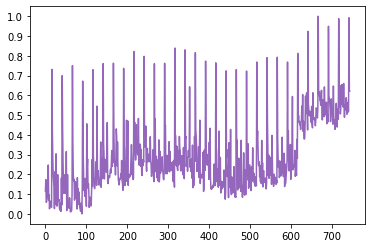

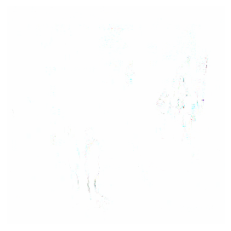

In [20]:
# for i in range(3):
show_one_result(result_dict, samples, 3200)
# input()
# break